## Import Modules


In [56]:
import pandas as pd
import numpy as np

from  cbcdb import DBManager
import datetime
from dotenv import load_dotenv, find_dotenv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping


def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

## Read in Data

In [2]:
load_dotenv(find_dotenv())
db = DBManager()

In [59]:
sql = """
        create temporary table consecutive_days as (
            select uid
                 , datetime_
                 , rank_group
                 , visit_number
                 , max(visit_number) over (partition by uid) as max_num_visit
                 , case
                       when (max_num_visit) > 1 then 1
                       else 0 end                            as visit_more_than_once
            from (
                     select uid
                          , datetime_
                          , rank_group
                          , rank() over (partition by uid order by rank_group asc) as visit_number
                     from (
                              SELECT uid
                                   , datetime                                                                  as datetime_
                                   , dateadd(day, -rank() OVER (partition by uid ORDER BY datetime), datetime) AS rank_group
                              FROM (SELECT DISTINCT t.location_id || '_' || t.animal_id as uid
                                                  , trunc(t.datetime_date)              as datetime
                                    from bi.transactions t
                                             inner join bi.animals a
                                                        on a.ezyvet_id = t.animal_id
                                                            and a.location_id = t.location_id
                                    order by 1, 2))));
        
        create temporary table wellness as (
            select wm.location_id || '_' || wm.animal_id                 as uid
                 , date(datetime_start_date)                             as datetime_
                 , wm.wellness_plan                                      as wellness_plan_num
                 , DATEDIFF(MONTH, wm.datetime_start_date, CURRENT_DATE) as months_a_member
                 , wp.name                                               as wellness_plan
            from pwa_bi.bi.wellness_membership wm
                     left join bi.wellness_plans wp
                               on wp.location_id = wm.location_id
                                   and wp.ezyvet_id = wm.wellness_plan
                     left join bi.animals a
                               on a.location_id = wm.location_id
                                   and a.ezyvet_id = wm.animal_id);
        -- where wp.active = 1
        --  and wm.status = 'Active');
        
        select f1.uid
             , f1.breed
             , f1.ani_age
             , f1.date
             , f1.weight
             , f1.is_medical
             , f1.product_group
             --, f1.type_id
             , f1.wellness_plan
             --, f1.months_a_member
             , f1.visit_number
             , f1.visit_more_than_once
             , f1.max_num_visit
             , f1.first_visit_spend
             , f1.total_future_spend
        from (
                     select f.uid
                      , f.breed
                      , f.ani_age
                      , f.date
                      , f.weight
                      , f.is_medical
                      --, f.tracking_level
                      , f.product_group
                      , f.type_id
                      , cd.visit_number
                      , cd.visit_more_than_once
                      , cd.max_num_visit
                      ,  max(case when w.wellness_plan is null then 0 else 1 end)
                        over (partition by f.uid)  as wellness_plan
                      --, w.months_a_member
                      , sum(case when cd.visit_number != 1 then f.revenue else 0 end)
                        over (partition by f.uid) as total_future_spend
                      , sum(case when cd.visit_number = 1 then f.revenue else 0 end)
                        over (partition by f.uid) as first_visit_spend
                 from (
                          select t.location_id || '_' || t.animal_id                                                         as uid
                               , a.breed
                               , max(
                                  date_diff('years', timestamp 'epoch' + a.date_of_birth * interval '1 second',
                                            current_date))                                                                   as ani_age
                               --, min(trunc(t.datetime_date)) over (partition by t.location_id || '_' || t.animal_id) as      date_of_first_visit
                               , case when trunc(t.datetime_date) - min(trunc(t.datetime_date)) over (partition by t.location_id || '_' || t.animal_id) > 548 then 0
                                   else 1 end as less_than_1_5_yeras
                                , case when current_date - min(trunc(t.datetime_date)) over (partition by t.location_id || '_' || t.animal_id) <  270 then 0
                                   else 1 end as recent_patient
                               , trunc(t.datetime_date)                                                                      as date
                               , a.weight
                               , p.is_medical
                                , case when  p.product_group like 'Retail%' then 'Retail'
                                        when p.product_group in ('Boarding','Daycare','Daycare Packages') then 'Boarding'
                                        when p.product_group like 'Medication%' then 'Medication'
                                        when p.product_group like  ('Referrals%') then 'Referrals'
                                        when p.product_group in ('to print','To Print','Administration') then 'admin'
                                        else p.product_group end as product_group
                               , case
                                     when apt.type_id like 'Grooming%' then 'groom'
                                     when apt.type_id like '%Neuter%' then 'neurtering'
                                     when apt.type_id like '%ental%' then 'dental'
                                     else apt.type_id end                                                                    as type_id
                               --, p.name
                               --, p.type
                               --, p.tracking_level
                               , t.revenue                                                                                   as revenue
                               , dense_rank()
                                 over (partition by t.location_id || '_' || t.animal_id order by trunc(t.datetime_date) asc) as rank_
                          from bi.transactions t
                                   inner join bi.products p
                                              on t.product_id = p.ezyvet_id
                                                  and t.location_id = p.location_id
                                   inner join bi.animals a
                                              on a.id = t.animal_id
                                   left join bi.contacts c
                                             on a.contact_id = c.ezyvet_id
                                                 and t.location_id = c.location_id
                                   left join bi.appointments apt
                                             on a.contact_id = apt.ezyvet_id
                                                 and t.location_id = apt.location_id
                                -- where
                                -- type_id not in ('Cancellation')
                                -- p.name not like '%Subscri%'
                                --  and p.product_group != 'Surgical Services'
                                -- and a.breed != '0.0'
                          group by 1, 2, 6, 7, 8, 9, 10,11) f
                  left join consecutive_days cd
                            on f.uid = cd.uid
                                and f.date = cd.datetime_
                  left join wellness w
                            on f.uid = w.uid
                                and f.date = w.datetime_
                    where less_than_1_5_yeras = 1
                            and recent_patient = 1) f1
        where f1.visit_number = 1
        order by 1, 4;"""
df = db.get_sql_dataframe(sql)
#df.to_csv('customer_retention_prod/data/data.csv')

2021-08-13 09:15:29,711| ERROR   | Password is required for key /Users/adhamsuliman/.ssh/id_rsa
2021-08-13 09:15:32,573| ERROR   | Could not establish connection from local ('127.0.0.1', 5401) to remote ('pwa.czsn4sr4vgrv.us-east-2.redshift.amazonaws.com', 5439) side of the tunnel: 


In [60]:
df_breed = db.get_sql_dataframe("select * from bi.breeds")
df = df.merge(df_breed, on=['breed'])

2021-08-13 09:15:32,664| ERROR   | Password is required for key /Users/adhamsuliman/.ssh/id_rsa


In [84]:
df.columns

Index(['uid', 'breed', 'ani_age', 'date', 'weight', 'is_medical',
       'product_group', 'wellness_plan', 'visit_number',
       'visit_more_than_once', 'max_num_visit', 'first_visit_spend',
       'total_future_spend', 'id', 'tier', 'breed_group'],
      dtype='object')

In [85]:
df_group = df[['first_visit_spend','total_future_spend','tier','breed_group']].drop_duplicates()

<AxesSubplot:xlabel='first_visit_spend', ylabel='total_future_spend'>

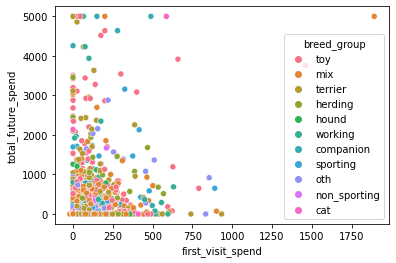

In [88]:
sns.scatterplot(x='first_visit_spend',y='total_future_spend',data=df_group,hue='breed_group')

<AxesSubplot:xlabel='first_visit_spend', ylabel='total_future_spend'>

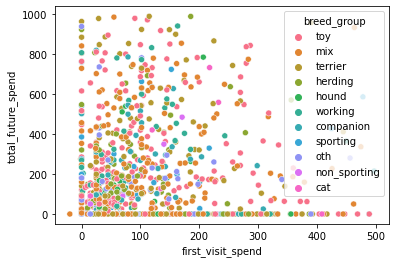

In [91]:
sns.scatterplot(x='first_visit_spend',y='total_future_spend',data=df_group[(df.first_visit_spend<500)&(df.total_future_spend<1000)],hue='breed_group')

<AxesSubplot:xlabel='first_visit_spend', ylabel='total_future_spend'>

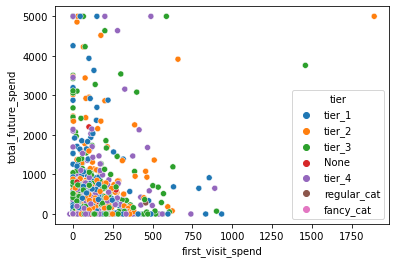

In [86]:
sns.scatterplot(x='first_visit_spend',y='total_future_spend',data=df_group,hue='tier')

<AxesSubplot:xlabel='first_visit_spend', ylabel='total_future_spend'>

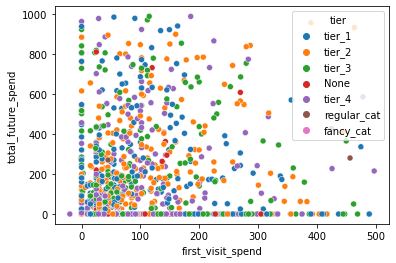

In [92]:
sns.scatterplot(x='first_visit_spend',y='total_future_spend',data=df_group[(df.first_visit_spend<500)&(df.total_future_spend<1000)],hue='tier')

<AxesSubplot:xlabel='first_visit_spend', ylabel='total_future_spend'>

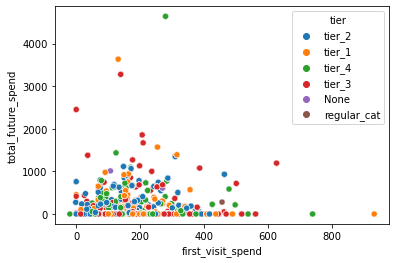

In [95]:
df_medical = df.groupby(['uid'], as_index=False)['is_medical'].sum()
df_medical = df_medical[df_medical.is_medical>=1].merge(df, on='uid')

sns.scatterplot(x='first_visit_spend',y='total_future_spend',data=df_medical,hue='tier')

<AxesSubplot:xlabel='first_visit_spend', ylabel='total_future_spend'>

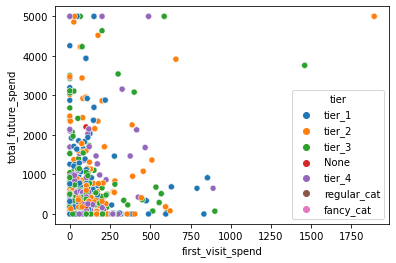

In [100]:
df_non_medical = df.groupby(['uid'], as_index=False)['is_medical'].sum()
df_non_medical = df_non_medical[df_non_medical.is_medical==0].merge(df, on='uid')

sns.scatterplot(x='first_visit_spend',y='total_future_spend',data=df_non_medical,hue='tier')

In [101]:
df_non_medical.uid.nunique()

1128

In [102]:
df_non_medical[df_non_medical['first_visit_spend']==0].groubpy()

131

In [61]:
print(f"Out of {df.uid.nunique()}, there are {df[((df.weight.isnull()) | (df.weight == 0.0))]['uid'].nunique()} animals with null weight)")
print(f"Out of {df.uid.nunique()}, there are {df[df.ani_age.isnull()]['uid'].nunique()} animals with null age)")

print(f"Number of unique id\'s : {df.uid.nunique()}")
print(f"There are {df[df.total_future_spend > 5000]['uid'].nunique()} patients who have spent more than 5k")
print(f"There are {df[df.total_future_spend < 0]['uid'].nunique()} patients who have somehow spent less than $0")
df.reset_index(drop=True, inplace=True)
df_ = df[['uid', 'ani_age', 'weight', 'is_medical', 'product_group',  'breed_group', 'tier', #'type_id',
    'wellness_plan', 'first_visit_spend', 'total_future_spend']]

Out of 2078, there are 605 animals with null weight)
Out of 2078, there are 472 animals with null age)
Number of unique id's : 2078
There are 19 patients who have spent more than 5k
There are 3 patients who have somehow spent less than $0


In [62]:
df['total_future_spend'] = df.total_future_spend.apply(lambda x: 5000 if x > 5000 else x)
df['total_future_spend'] = df.total_future_spend.apply(lambda x: 0 if x < 0 else x)
df = df[((df.ani_age.notnull()) & (df.weight.notnull()))]

## Create categorical df. Number of rows should equate to the number of unique uid

In [63]:
df_.product_group.value_counts()

Boarding                    1060
Professional Services        853
Medication                   662
Grooming (Full Service)      557
Vaccinations                 477
Staff Bath                   475
Parasite Control             248
Retail                       162
Promotions                   127
Diagnostics                  118
Laboratory - In-house        117
Laboratory - Antech          105
Wellness Plan Fees           101
Tips                          64
Dentistry & Oral Surgery      42
Euthanasia & Cremation        30
Supplements/OTCs              22
Anesthesia & Sedation         22
Surgical Services             21
Imaging                       18
RX Diets                      14
Add- On Services              11
Hospital Supplies             11
1800VetsNow                    8
Breeder/Rescue Packages        3
admin                          1
Name: product_group, dtype: int64

### How are we seeing spend with cancellation

In [ ]:
df.groupby('uid').filter(lambda x: len(x) ==5)


,uid,breed,ani_age,date,weight,is_medical,product_group,wellness_plan,visit_number,visit_more_than_once,max_num_visit,first_visit_spend,total_future_spend,id,tier,breed_group
29,3_2789,Havanese,7.0,2020-05-13,20.0,1,Professional Services,0,1,0,1,226.00,0.0,528,tier_1,toy
30,3_2789,Havanese,7.0,2020-05-13,20.0,1,Vaccinations,0,1,0,1,226.00,0.0,528,tier_1,toy
31,3_2789,Havanese,7.0,2020-05-13,20.0,1,Vaccinations,0,1,0,1,226.00,0.0,528,tier_1,toy
32,3_2789,Havanese,7.0,2020-05-13,20.0,0,Grooming (Full Service),0,1,0,1,226.00,0.0,528,tier_1,toy
33,3_2789,Havanese,7.0,2020-05-13,20.0,1,Vaccinations,0,1,0,1,226.00,0.0,528,tier_1,toy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5318,5_4805,Weimaraner6,NaN,2020-11-14,0.0,1,Professional Services,0,1,0,1,220.05,0.0,467,None,sporting
5319,5_4805,Weimaraner6,NaN,2020-11-14,0.0,1,Medication,0,1,0,1,220.05,0.0,467,None,sporting
5320,5_4805,Weimaraner6,NaN,2020-11-14,0.0,1,Vaccinations,0,1,0,1,220.05,0.0,467,None,sporting
5321,5_4805,Weimaraner6,NaN,2020-11-14,0.0,1,Promotions,0,1,0,1,220.05,0.0,467,None,sporting


In [ ]:
df[df.uid=='3_2789']

,uid,breed,ani_age,date,weight,is_medical,product_group,wellness_plan,visit_number,visit_more_than_once,max_num_visit,first_visit_spend,total_future_spend,id,tier,breed_group
29,3_2789,Havanese,7.0,2020-05-13,20.0,1,Professional Services,0,1,0,1,226.0,0.0,528,tier_1,toy
30,3_2789,Havanese,7.0,2020-05-13,20.0,1,Vaccinations,0,1,0,1,226.0,0.0,528,tier_1,toy
31,3_2789,Havanese,7.0,2020-05-13,20.0,1,Vaccinations,0,1,0,1,226.0,0.0,528,tier_1,toy
32,3_2789,Havanese,7.0,2020-05-13,20.0,0,Grooming (Full Service),0,1,0,1,226.0,0.0,528,tier_1,toy
33,3_2789,Havanese,7.0,2020-05-13,20.0,1,Vaccinations,0,1,0,1,226.0,0.0,528,tier_1,toy


In [ ]:
df_product_group = pd.get_dummies(df_.product_group)
#df_type = pd.get_dummies(df_.type_id)
df_wellness_plan = pd.get_dummies(df_.wellness_plan)
df_breed_group = pd.get_dummies(df_.breed_group)
df_tier = pd.get_dummies(df_.tier)

df_cat = pd.concat([df_[['uid']],
                    #df_type,
                    df_product_group,
                    df_wellness_plan,
                    df_breed_group,
                    df_tier], axis=1)  # .fillna(0)
df_cat = df_cat.groupby(['uid'], as_index=False).max()

## Create continuous df. 

In [ ]:
df_cont = df_[['uid', 'ani_age', 'weight', 'breed_group', 'tier', 'is_medical', 'product_group', #'type_id',
                    'first_visit_spend', 'total_future_spend']]
df_cont['ani_age'] = df_cont['ani_age'].fillna((df_cont['ani_age'].mean()))
df_cont['weight'] = df_cont['weight'].replace(0, np.nan)
df_cont['weight'] = df_cont.groupby(['ani_age', 'breed_group', 'tier'])['weight'].transform(
    lambda x: x.fillna(x.mean()))
df_cont['weight'] = df_cont.groupby(['breed_group', 'tier'])['weight'].transform(
    lambda x: x.fillna(x.mean()))

df_cont = df_cont.groupby(
    ['uid', 'ani_age', 'first_visit_spend', 'total_future_spend', 'weight'],
    as_index=False).agg(is_medical_max=('is_medical', 'max'),
                        is_medical_count=('is_medical', 'count'))

df_final = df_cont.merge(df_cat, on='uid')
df_final['total_future_spend'] = df_final.total_future_spend.apply(lambda x: 5000 if x > 5000 else x)
df_final['total_future_spend'] = df_final['total_future_spend'].apply(lambda x: 0 if x < 0 else x)
# df_final = df_final[((df_final.ani_age.notnull()) & (df_final.weight.notnull()))]
# df_final['weight'] = df_final['weight'].fillna((df_final['weight'].mean()))
# df_final['weight'] = df_final['weight'].apply(lambda x: df_final['weight'].mean() if x == 0 else x)

# Get dummies on tier and breed group
bins = [0, 1, 100, 250, 500, 99999]
labels = [0, 1, 2, 3, 4]
df_final['total_future_spend_bin'] = pd.cut(df_final['total_future_spend'], bins=bins, include_lowest=True,
                                            labels=labels)
print(f"Value Counts for labels: {df_final['total_future_spend_bin'].value_counts()}")


Value Counts for labels: 0    944
4    406
2    264
1    242
3    215
Name: total_future_spend_bin, dtype: int64


In [ ]:
cat_ex = df_cat[df_cat.uid=='3_2789']

In [65]:
cont_ex = df_cont[df_cont.uid=='3_2789']

In [66]:
final_ex = df_final[df_final.uid=='3_2789']

In [78]:
final_columns = list(df_final.columns)
for i in ['uid','total_future_spend','total_future_spend_bin']:
    final_columns.remove(i)

X = df_final[final_columns]
y = df_final['total_future_spend_bin'].apply(lambda x: int(x))
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = .2,
                                                    random_state = 42)

In [68]:
# Below will fail with a perfect separation error
res = sm.OLS(y_train, X_train).fit()
#res.params

#res2 = sm.GLM(y_train, Xs, family=sm.families.Binomial()).fit_regularized(L1_wt=0.0, alpha=0.1)
#params = res2.params

In [69]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     total_future_spend   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     13.88
Date:                Fri, 13 Aug 2021   Prob (F-statistic):           6.26e-88
Time:                        09:15:36   Log-Likelihood:                -13130.
No. Observations:                1656   AIC:                         2.636e+04
Df Residuals:                    1608   BIC:                         2.662e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
ani_age                     -0.9768      4.396     -0.222      0.824      -9.600       7.646
first_visit_spend            1.4143      0.152      9.309      0.000       1.116       1.712
weight                      -0.2081      0.361     -0.577      0.564      -0.916       0.500
is_medical_max              85.6121    148.623      0.576      0.565    -205.903     377.127
is_medical_count             5.5246     18.721      0.295      0.768     -31.195      42.244
1800VetsNow                 -7.0341    267.749     -0.026      0.979    -532.208     518.140
Add- On Services          -128.8357    246.774     -0.522      0.602    -612.868     355.197
Anesthesia & Sedation     -297.8749    304.752     -0.977      0.329    -895.627     299.877
Boarding                   253.9400     62.922      4.036      0.000     130.522     377.358
Breeder/Rescue Packages  -3.638e-12   1.97e-12     -1.847      0.065    -7.5e-12    2.26e-13
Dentistry & Oral Surgery   -10.3556    122.571     -0.084      0.933    -250.771     230.060
Diagnostics                -93.5674    101.128     -0.925      0.355    -291.924     104.789
Euthanasia & Cremation    -248.7130    189.487     -1.313      0.190    -620.381     122.955
Grooming (Full Service)    120.0795     63.810      1.882      0.060      -5.079     245.239
Hospital Supplies         -275.3802    255.643     -1.077      0.282    -776.809     226.049
Imaging                   -261.5324    188.483     -1.388      0.165    -631.230     108.165
Laboratory - Antech         19.6104     92.936      0.211      0.833    -162.679     201.899
Laboratory - In-house     -212.2221     89.522     -2.371      0.018    -387.814     -36.631
Medication                 -93.8525     73.554     -1.276      0.202    -238.124      50.419
Parasite Control            90.2741     68.787      1.312      0.190     -44.648     225.196
Professional Services      -29.4658    146.085     -0.202      0.840    -316.002     257.070
Promotions                  22.9028     84.831      0.270      0.787    -143.489     189.295
RX Diets                  -137.4964    220.080     -0.625      0.532    -569.170     294.177
Retail                     -46.4035     81.112     -0.572      0.567    -205.501     112.694
Staff Bath                  61.9378     54.675      1.133      0.257     -45.304     169.180
Supplements/OTCs          -201.3746    178.274     -1.130      0.259    -551.049     148.300
Surgical Services         -326.0545    285.575     -1.142      0.254    -886.192     234.083
Tips                       115.7279    107.729      1.074      0.283     -95.576     327.032
Vaccinations               -92.4033     75.163     -1.229      0.219    -239.831      55.025
Wellness Plan Fees        -685.4932    156.288     -4.386      0.000    -992.043    -378.943
admin         

In [70]:
import sklearn.metrics as metrics
#Generate predictions with the model using our X values
y_pred = res.predict(X_test)
y_pred = [0 if x < 0 else x for x in y_pred]
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(y_test,y_pred)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
#print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 381.39285831030026
MSE: 469076.4007229342
RMSE: 684.8915247854468


In [71]:
y_test = list(y_test)

In [72]:

# a list contains both even and odd numbers. 
seq = [0, 1, 2, 3, 5, 8, 13]
  
# result contains odd numbers of the list
result = filter(lambda x: x % 2 != 0, seq)

<AxesSubplot:ylabel='Density'>

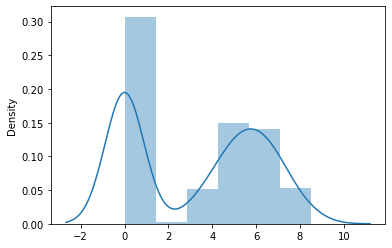

In [73]:
import seaborn
y_test_ = [np.log(x) if x != 0 else 0 for x in y_test]
seaborn.distplot(a=y_test_)

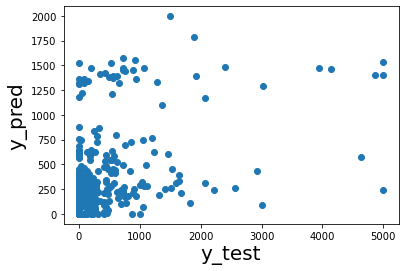

In [74]:
import matplotlib.pyplot as plt
residuals =  np.array(y_test) - np.array(y_pred)
plt.scatter(y_test,y_pred)
plt.xlabel("y_test", size = 20)
plt.ylabel("y_pred", size = 20)
plt.show()

In [81]:
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1]))
model.add(LeakyReLU(alpha=.05))
model.add(Dense(256, input_dim=X_train.shape[1]))
model.add(LeakyReLU(alpha=.05))
model.add(Dense(128))
model.add(LeakyReLU(alpha=.05))
model.add(Dense(len(labels), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss',
                    mode='min',
                    verbose=1,
                    patience=4)



class_weights = class_weight.compute_class_weight('balanced',
                                                    np.unique(labels),
                                                    list(df_final['total_future_spend_bin'].astype(int).values))
class_weights = dict(enumerate(class_weights))

model.fit(X_train,
                y_train,
                epochs=100,
                batch_size=10,
                validation_split=.2,
                callbacks=[es],
                class_weight=class_weights)


Train on 1324 samples, validate on 332 samples
Epoch 1/100
1324/1324 [==============================] - 0s 327us/sample - loss: 3.1345 - acc: 0.2289 - val_loss: 2.2397 - val_acc: 0.4127
Epoch 2/100
1324/1324 [==============================] - 0s 154us/sample - loss: 1.8924 - acc: 0.2198 - val_loss: 1.7062 - val_acc: 0.1235
Epoch 3/100
1324/1324 [==============================] - 0s 144us/sample - loss: 1.7936 - acc: 0.2304 - val_loss: 1.8579 - val_acc: 0.1837
Epoch 4/100
1324/1324 [==============================] - 0s 156us/sample - loss: 1.6239 - acc: 0.2251 - val_loss: 1.6872 - val_acc: 0.1988
Epoch 5/100
1324/1324 [==============================] - 0s 147us/sample - loss: 1.6432 - acc: 0.2251 - val_loss: 1.6591 - val_acc: 0.2289
Epoch 6/100
1324/1324 [==============================] - 0s 156us/sample - loss: 1.6222 - acc: 0.2402 - val_loss: 1.6658 - val_acc: 0.3193
Epoch 7/100
1324/1324 [==============================] - 0s 161us/sample - loss: 1.6104 - acc: 0.2447 - val_loss: 1.726

In [ ]:
import sklearn.metrics as metrics
#Generate predictions with the model using our X values
y_pred = model.predict(X_test)
y_pred = [0 if x < 0 else x[0] for x in y_pred]
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(y_test,y_pred)

print("Results of sklearn.metrics:")
print("MAE:",np.round(mae,1))
print("MSE:", np.round(mse,1))
print("RMSE:", np.round(rmse,1))
print("R-Squared:", np.round(r2,2))

Results of sklearn.metrics:
MAE: 2.8
MSE: 11.6
RMSE: 3.4
R-Squared: -0.46


In [231]:
len(X_train)

532

In [232]:
len(X_test)

133